In [1]:
import numpy as np
import pandas as pd
import scipy.stats as sc_stats
import matplotlib.pyplot as plt

In [2]:
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({
  'font.size': 12,
  'grid.alpha': 0.25})

## Function declarations

### Read `ods` to `DataFrame`


In [3]:
def read_ods(filename, columns):
  key_arr = (k for k in columns.keys())
  df = pd.read_excel(filename, engine="odf", header=0,
                     usecols=columns)
  df = df.rename(columns=columns)
  return df

### Standard error of autocorrelation


In [4]:
def std_error(r_k_arr, k, n):
  r_k_arr = np.array(r_k_arr)
  r_k_arr = r_k_arr[:k-1] if len(r_k_arr) > 1 else [0]
  r_k_arr = np.array(r_k_arr)
  return np.sqrt((1 + 2*sum(r_k_arr**2))/n)


### Compute `r_k`, `t_test`, and `LBQ`

In [5]:
def get_correlogram(dataframe, up_to_lag, columns=[None, None], 
                    significance_lvl=0.05):
  df = dataframe.copy()

  Y_t = df[columns[1]].to_numpy()

  mean_Y_t = np.mean(Y_t)

  r_lag_arr = np.empty(up_to_lag)
  denom = np.sum((Y_t - mean_Y_t)**2)

  num_of_samples = len(Y_t)
  dof = num_of_samples - 1   # degree of freedom
  l_bound = sc_stats.t.ppf(significance_lvl/2, dof)
  u_bound = sc_stats.t.ppf(1-significance_lvl/2, dof)
  #print(f"[l_bound, r_bound] = [{l_bound}, {u_bound}]")

  std_error_arr = np.empty(up_to_lag)
  significance_lim_arr = np.empty([up_to_lag, 2])

  t_test_arr = np.empty(up_to_lag)

  # Ljung-Box Q statistic
  coeff = num_of_samples*(num_of_samples + 2)
  LBQ_arr = np.empty(up_to_lag)

  for lag in range(1, up_to_lag+1):
    numer = (Y_t[:-lag]  - mean_Y_t) * (Y_t[lag:] - mean_Y_t)
    numer = np.sum(numer)
    # print(f"numer = {numer}")
    # print(f"denom = {denom}")
    r_lag = numer / denom
    r_lag_arr[lag-1] = r_lag 
    std_error_arr[lag-1] = std_error(r_lag_arr[:lag], lag, num_of_samples)
    #print(f"std_error_r_{lag:<2d}: {std_error_arr[lag-1]}")
    significance_lim_arr[lag-1, 0] = l_bound*std_error_arr[lag-1]
    significance_lim_arr[lag-1, 1] = u_bound*std_error_arr[lag-1]

    t_test_arr[lag-1] = r_lag / std_error_arr[lag-1]
    # print(f"r_{lag:<2d} = {r_lag_arr[lag-1]:9.6f}")

    LBQ_arr[lag-1] = coeff*np.sum((r_lag_arr[:lag]**2)/(num_of_samples - np.arange(1, lag+1)))


  df_result = pd.DataFrame({
    "k": np.arange(1, up_to_lag+1), 
    "r_k": r_lag_arr, 
    "t_test": t_test_arr, 
    "LBQ": LBQ_arr,
    "l_bound": significance_lim_arr[:,0],
    "u_bound": significance_lim_arr[:,1]  
  })
  return df_result

### Plot of autocorrelation function

In [6]:
def plot_autocorr_func(df_acorr_analysis):
  fig, ax = plt.subplots(figsize=(7, 3))

  lag_arr = df_acorr_analysis["k"].to_numpy()
  stem_handler = ax.stem(lag_arr, df_acorr_analysis["r_k"].to_numpy())

  ax.plot(lag_arr, df_acorr_analysis["l_bound"], linestyle='--', color="gray")
  ax.plot(lag_arr, df_acorr_analysis["u_bound"], linestyle='--', color="gray")

  # [0] = markerline handler
  # [1] = stemlines handler
  # [2] = baseline handler
  stem_handler[0].set_marker(None)
  stem_handler[1].set_linewidth(4)
  stem_handler[2].set_alpha(0)

  ax.grid("on")
  ax.set_ylim([-1.1, 1.1])
  ax.set_xlabel("Lag")
  ax.set_ylabel("Autocorrelation")
  ax.set_title("Autocorrelation Function for Yt\n"
    + "(with 5% significance limits for the autocorrelations)")

  plt.show(fig)


In [7]:
filename = "02-table-04-sears-operating-revenue.ods"
df = read_ods(filename, {"Year": "t", "Yt": "Y_t"})
df.head()

,t,Y_t
0,1955,3307
1,1956,3556
2,1957,3601
3,1958,3721
4,1959,4036


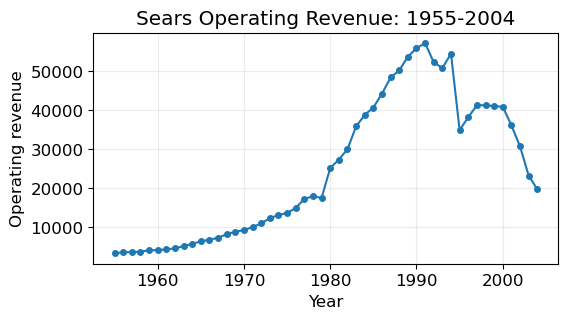

In [8]:
fig, ax = plt.subplots(figsize=(6, 3))

ax.plot(df["t"], df["Y_t"], marker='o', markersize=4)
ax.set_xlabel("Year")
ax.set_ylabel("Operating revenue")
ax.set_title("Sears Operating Revenue: 1955-2004")
ax.grid("on")
plt.show(fig)

## Moving average residuals

In [9]:
df_movave = df.copy()
df_movave["hat_Y_t"] = df_movave["Y_t"].rolling(window=5).mean().shift(1)
df_movave["e_t"] = df_movave["Y_t"] - df_movave["hat_Y_t"]
df_movave = df_movave.dropna().reset_index(drop=True)
df_movave.head()

,t,Y_t,hat_Y_t,e_t
0,1960,4134,3644.2,489.8
1,1961,4268,3809.6,458.4
2,1962,4578,3952.0,626.0
3,1963,5093,4147.4,945.6
4,1964,5716,4421.8,1294.2


In [10]:
num_of_rk = 10
df_acorr_analysis = get_correlogram(df_movave, num_of_rk, columns=['t', "e_t"])
df_acorr_analysis


,k,r_k,t_test,LBQ,l_bound,u_bound
0,1,0.767355,5.147571,28.304134,-0.300433,0.300433
1,2,0.577829,2.626699,44.726707,-0.443347,0.443347
2,3,0.452556,1.799716,55.040208,-0.506784,0.506784
3,4,0.302645,1.125281,59.765121,-0.542035,0.542035
4,5,0.242298,0.876572,62.869320,-0.557078,0.557078
5,6,0.260305,0.926039,66.543934,-0.566511,0.566511
6,7,0.263140,0.918779,70.397844,-0.577205,0.577205
7,8,0.213366,0.731392,73.000143,-0.587934,0.587934
8,9,0.092468,0.313266,73.502471,-0.594881,0.594881
9,10,-0.080688,-0.272764,73.895892,-0.596177,0.596177


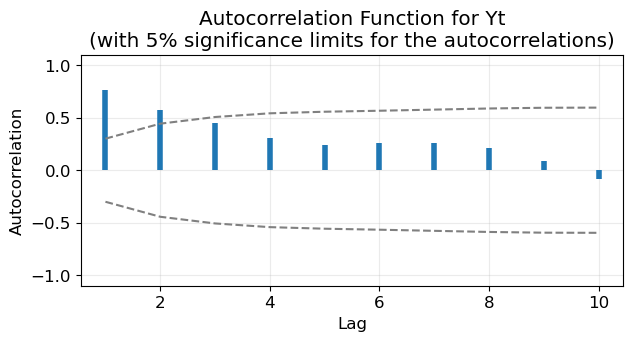

In [11]:
plot_autocorr_func(df_acorr_analysis)


## Holt's linear exponential smoothing

We will cover this topic in the next lecture. 